# Giriş

Bu notebookta bize verilen veri setindeki haber başlıklarını, haber açıklamalarını ve haber kategorilerini kullanarak gözetimli bir makine öğrenmesi modeli kuracağız.Kullanılacak olan veri seti HuffPost adlı haber sitesinin 2012’den 2021’kadarlık bir periyotta toplam 210 bin haber başlığından oluşuyor.

# İçerik:

0. Gerekli Kütüphanler
1. Veri keşfi ve veri ön işleme

  - Veriyi içeri alma ve keşfetme
  - Hedef değişken analizi
  - Veri ön işleme
  
  
2. Tokenizasyon
  - Tokenizasyon örneği
  - Veri setine uygulama
3. Word Emmbedings
  - Basit bir modelle word embeddingleri öğrenme
  - Word embedding görselleştirme
4. Sequential Modeller
  - Recurrent Neural Networks
  - Long Short Term Memory

5. Tahminleme



# 0. Gerekli Kütüphaneler

<a id="lib"></a>


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
nltk.download('wordnet')
from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from sklearn.preprocessing import LabelEncoder

from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
import warnings 
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",500)


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# 1. Veri Keşfi ve Veri ön işleme

<a id="eda"></a>


## Veriyi içeri alma ve keşfetme

In [3]:
# Pandas read_json metodu ile veri içeri import edildi
# Lines argumanı satır başına bir json nesnesi olarak okutmak için
path = "data/News_Category_Dataset_v3.json"

df = pd.read_json(path,lines = True) 

print(f"Veri seti boyutu {df.shape}")
df.head()

Veri seti boyutu (209527, 6)


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


* **link:** Haberin bağlantısı.
* **headline:** Haberin başlığı.
* **category:** Haberin ait olduğu kategori (Komedi,Politika,Spor vs.).
* **short_description:** Haberin kısa özeti.
* **authors:** Haberin yazarı.
* **date:** Haberin yayınlandığı tarih

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [ ]:
print(f'Tekrar eden kayıt sayısı: {df.duplicated().sum()}')
# Tekar eden kayıtları çıkar
df = df[~df.duplicated()]
print(f"Tekar eden kayılar çıkarıldıktan sonra: {df.duplicated().sum()}")

Tekrar eden kayıt sayısı: 13

Tekar eden kayılar çıkarıldıktan sonra: 0


## Hedef Değişken Analizi

In [10]:
df["category"].value_counts()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

In [12]:
n_categories = df["category"].nunique()
print(f"Toplam kategori sayısı: {n_categories}")

Toplam kategori sayısı: 42


#### Sütün Grafiği

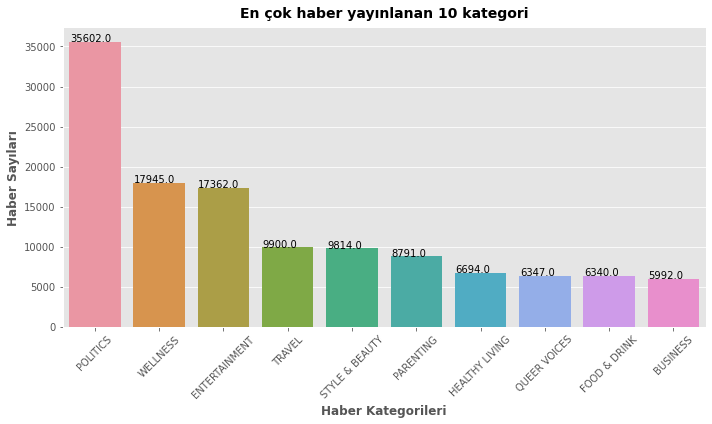

In [ ]:
cat_df = pd.DataFrame(df["category"].value_counts()).reset_index()
cat_df.rename(columns={"index" : "news_category", "category" : "counts"},inplace = True)

# Barplot
plt.figure(figsize = (10,6))
ax = sns.barplot(x = np.array(cat_df.news_category)[:10],y = np.array(cat_df.counts)[0:10])

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 50))

plt.title("En çok haber yayınlanan 10 kategori")
plt.xlabel("Haber Kategorileri")
plt.ylabel("Haber Sayıları")
plt.xticks(rotation = 45)
plt.show()

Görüldüğü üzere haber kategorilerinde baskın olan grubun Politika olduğunu görüyoruz.

Onun ardından Wellness(Sağlık), Eğlence(Entertainment), Travel(Seyahat) kategorileri geliyor. 

#### Pasta Grafiği

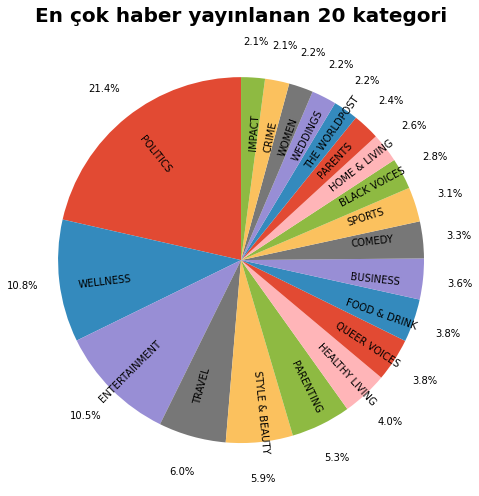

In [ ]:
fig = plt.figure(figsize=(7,7))
plt.pie(cat_df["counts"][:20],
        labels=cat_df["news_category"][0:20],
        autopct = "%1.1f%%",
        startangle = 90,
        labeldistance = 0.6,
        pctdistance = 1.2,
        rotatelabels = 45
        )


plt.title("En çok haber yayınlanan 20 kategori", size=20, weight='bold')

plt.show()

Burada da en çok haber yayınlanan ilk 20 kategoriyi bir pasta grafiği üzerinde görüyoruz.

#### Kelime Bulutları

Kelime bulutları bir metinde en çok geçen kelimeleri görmemizi sağlayan bir görselleştirme yöntemidir

(-0.5, 1199.5, 599.5, -0.5)

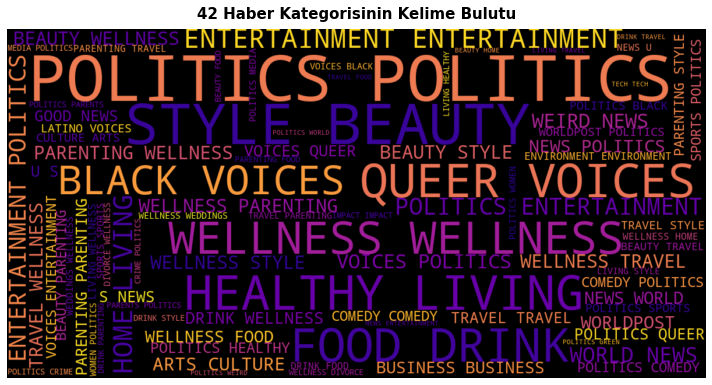

In [5]:
plt.figure(figsize=(10,10))
wc = WordCloud(
    max_words = 1000,
    min_font_size = 10,
    height = 600,
    width = 1200,
    background_color='black',
    contour_color='black',
    colormap='plasma',
    repeat = False,
    stopwords = STOPWORDS
).generate(" ".join(df.category))

plt.title("42 Haber Kategorisinin Kelime Bulutu", size=15, weight='bold')
plt.imshow(wc,interpolation = "bilinear")
plt.axis("off")

(-0.5, 1599.5, 599.5, -0.5)

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

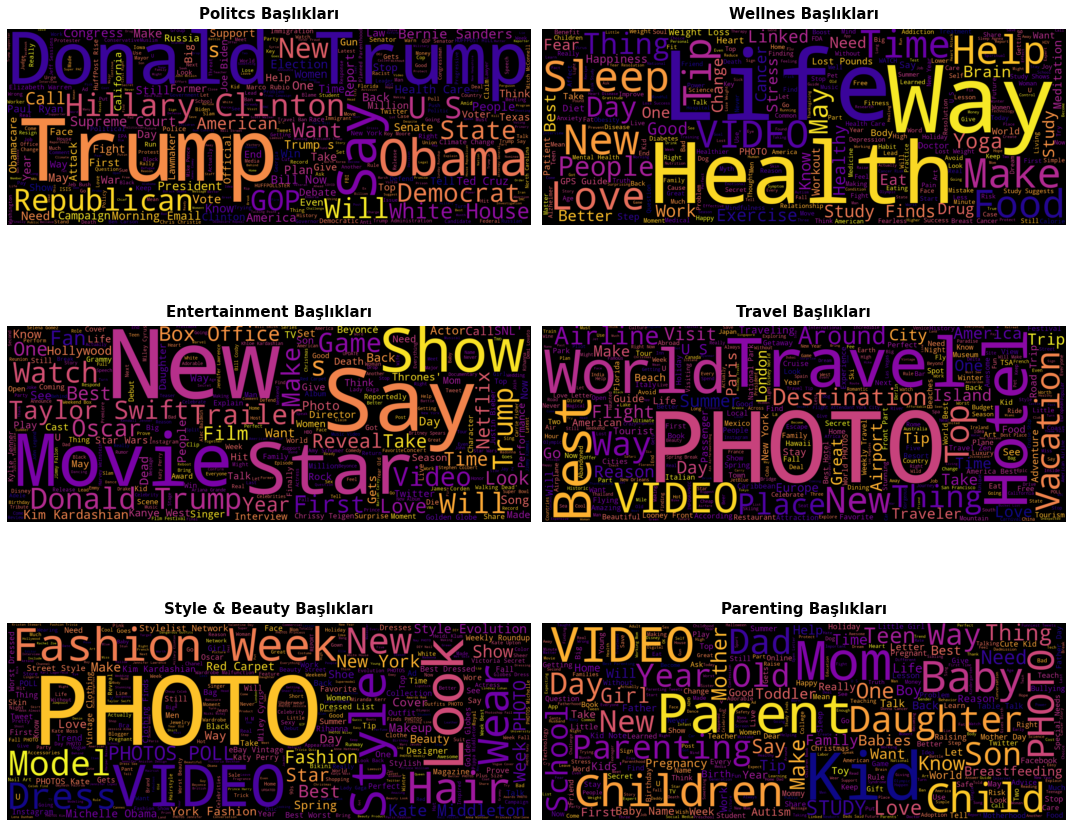

In [ ]:
# POLITICS 
def category_headline_wc(category_name):
  plt.figure(figsize=(12,12))
  head_cat = df.loc[df["category"] == category_name,"headline"]
  wc_politcs_headline = WordCloud(
      max_words = 1000,
      min_font_size = 10,
      height = 600,
      width = 1600,
      background_color='black',
      contour_color='black',
      colormap='plasma',
      repeat = False,
      stopwords = STOPWORDS
  ).generate(" ".join(head_cat))

  return wc_politcs_headline

politcs = category_headline_wc("POLITICS")
wellness = category_headline_wc("WELLNESS")
entertainment = category_headline_wc("ENTERTAINMENT")
travel = category_headline_wc("TRAVEL")
style_beauty = category_headline_wc("STYLE & BEAUTY")
parenting = category_headline_wc("PARENTING")

plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
plt.title("Politcs Başlıkları", size=15, weight='bold')
plt.imshow(politcs,interpolation = "bilinear")
plt.axis("off")

plt.subplot(3,2,2)
plt.title("Wellnes Başlıkları", size=15, weight='bold')
plt.imshow(wellness,interpolation = "bilinear")
plt.axis("off")

plt.subplot(3,2,3)
plt.title("Entertainment Başlıkları", size=15, weight='bold')
plt.imshow(entertainment,interpolation = "bilinear")
plt.axis("off")

plt.subplot(3,2,4)
plt.title("Travel Başlıkları", size=15, weight='bold')
plt.imshow(travel,interpolation = "bilinear")
plt.axis("off")

plt.subplot(3,2,5)
plt.title("Style & Beauty Başlıkları", size=15, weight='bold')
plt.imshow(style_beauty,interpolation = "bilinear")
plt.axis("off")

plt.subplot(3,2,6)
plt.title("Parenting Başlıkları", size=15, weight='bold')
plt.imshow(parenting,interpolation = "bilinear")
plt.axis("off")

## Veri Ön İşleme

Makine öğrenmesi aşamasına girmeden önce verileri algoritmaların üzerinde işlem yapabilecekleri şekile getirmeliyiz. 

Bu işlemlere veri ön işleme denir.

In [ ]:
# headline ve short_descripton birleştir ve yeni değişkene ata
df["headline_and_description"] = df["headline"] + df["short_description"]

# Gereksizi sütünları çıkar
drop_cols = ["link","headline","short_description","authors","date"]
df.drop(drop_cols,axis = 1,inplace = True)

In [ ]:
df.head()

,category,headline_and_description
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li..."
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...
3,PARENTING,The Funniest Tweets From Parents This Week (Se...
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...


In [ ]:
# Metinleri regex kullanarak temizleme fonksiyonu 
def clean_text(text):
    whitespace = re.compile(r"\s+") 
    user = re.compile(r"(?i)@[a-z0-9_]+")  
    text = whitespace.sub(' ', text) # metindeki birden fazla boşluk karakterlerini tek boşluğa dönüştür
    text = user.sub('', text) # metindeki kullanıcı adlarını siler
    text = re.sub(r"\[[^()]*\]","", text) # köşeli parantezle kapatılmış olan kelimeleri siler
    text = re.sub("\d+", "", text) # sayıları kaldırır
    text = re.sub(r'[^\w\s]','',text) # nokta,virgül,soru işareti gibi noktalama işaretlerini kaldırır
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text) # hastag,@, link gibi işaretleri kaldırır.
    text = text.lower() # metinleri küçük harflere çevirir
    
    # stop-wordleri çıkarır
    text = [word for word in text.split() if word not in list(STOPWORDS)]

    # kelimeleri eklerden ayırıp köklerini elde etme
    sentence = []
    for word in text:
      lemmatizer = WordNetLemmatizer()
      sentence.append(lemmatizer.lemmatize(word,'v'))

    return " ".join(sentence)

In [ ]:
# Örnek
random_text = df['headline_and_description'].sample().values[0]
random_text_cleaned = clean_text(random_text)

print(f"Temizlemeden önce:\n{random_text}")
print(f"Temizlendikten sonra:\n{random_text_cleaned}")

Temizlemeden önce:

New Campaign Seeks To Help Sleep-Deprived Americans

Temizlendikten sonra:

new campaign seek help sleepdeprived americans


In [ ]:
# yazılan fonksiyou uygula 
df['headline_and_description'] = df['headline_and_description'].apply(clean_text)

In [ ]:
df.head()

,category,headline_and_description
0,U.S. NEWS,million americans roll sleeves omicrontargeted...
1,U.S. NEWS,american airlines flyer charge ban life punch ...
2,COMEDY,funniest tweet cat dog week sept dog dont unde...
3,PARENTING,funniest tweet parent week sept accidentally p...
4,U.S. NEWS,woman call cop black birdwatcher lose lawsuit ...


# 2. Tokenizasyon

**1. Tokenization**
- Bir yapay sinir ağını eğitmeye başlamadan önce metinleri sayısal şekillerde temsil etmemiz gerekmektedir. Bu temsil etme işine tokenization denir.



<a id="tv"></a>

#### Tokenizasyon Örneği

In [ ]:
sentences = [
    "Dokuz Eylül Üniversitesi Yönetim Bilişim Sistemleri",
    "Dokuz Eylül Üniversitesi Ekonometri"
]
print(sentences)

tokenizer = Tokenizer(num_words = 100,oov_token="<OOV>")
        
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index

print(word_index)

['Dokuz Eylül Üniversitesi Yönetim Bilişim Sistemleri', 'Dokuz Eylül Üniversitesi Ekonometri']

{'<OOV>': 1, 'dokuz': 2, 'eylül': 3, 'üniversitesi': 4, 'yönetim': 5, 'bilişim': 6, 'sistemleri': 7, 'ekonometri': 8}


**2. Text to Sequences**
- Girdi olarak verilen cümleleri tokenlerden oluşan dizilere(sequence) çevirme işlemidir.


In [ ]:
sequences = tokenizer.texts_to_sequences(sentences)

print(sequences)

[[2, 3, 4, 5, 6, 7], [2, 3, 4, 8]]


**2. Padding**
- Yapay sinir ağı modelleri bütün dizilerin unifrom boyutta olmasını ister.Bu nedenle bütün diziler aynı boyutta olacak şekilde 0'lar ile doldurulur. 

In [ ]:
padded = pad_sequences(sequences,maxlen=6)
print(padded)

[[2 3 4 5 6 7]

 [0 0 2 3 4 8]]


**2. Out of Vocabulary**
- Out of Vocabulary tokeni, sözlükte bulunmayan bir kelimeyi içeren cümle girdi olarak verildiğinde kullanılır. 

In [ ]:
test_data = [
    "Dokuz Eylül Üniversitesi İşletme",
    "Boğaziçi Üniversitesi Yönetim Bilişim Sistemleri"
]

test_seq = tokenizer.texts_to_sequences(test_data)

# Print word index dictionary
print("\nWord Index = " , word_index)

# Print sequences 
print("\nTest Sequence = ", test_seq)

# Print padded sequences
padded_test = pad_sequences(test_seq, maxlen=10)
print("\nPadded Test Sequence: ")
print(padded_test)



Word Index =  {'<OOV>': 1, 'dokuz': 2, 'eylül': 3, 'üniversitesi': 4, 'yönetim': 5, 'bilişim': 6, 'sistemleri': 7, 'ekonometri': 8}



Test Sequence =  [[2, 3, 4, 1], [1, 4, 5, 6, 7]]



Padded Test Sequence: 

[[0 0 0 0 0 0 2 3 4 1]

 [0 0 0 0 0 1 4 5 6 7]]


## Veri Setine Uygulama

- **Kategorileri Encode Etme**


In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(df["category"]) # bağımlı değişken y
print("Encode edilmeden önce:",df["category"].values)
print("Encode edildikten sonra:",y)

Encode edilmeden önce: ['U.S. NEWS' 'U.S. NEWS' 'COMEDY' ... 'SPORTS' 'SPORTS' 'SPORTS']

Encode edildikten sonra: [35 35  5 ... 28 28 28]


In [ ]:
# bağımsız değişkenler
X = df["headline_and_description"]
print(X.head())

0    million americans roll sleeves omicrontargeted...

1    american airlines flyer charge ban life punch ...

2    funniest tweet cat dog week sept dog dont unde...

3    funniest tweet parent week sept accidentally p...

4    woman call cop black birdwatcher lose lawsuit ...

Name: headline_and_description, dtype: object


In [ ]:
print("Girdilerin boyutu",X.shape)
print("Çıktıların boyutu",y.shape)

Girdilerin boyutu (209527,)

Çıktıların boyutu (209527,)


- **Eğitim ve Test kümelerine bölme**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

print(f"Eğitim kümesinin boyutu: X={X_train.shape} y={y_train.shape}")
print(f"Test kümesinin boyutu: X={X_test.shape} y={y_test.shape}")

Eğitim kümesinin boyutu: X=(167621,) y=(167621,)

Test kümesinin boyutu: X=(41906,) y=(41906,)


- **Tokenizasyon**

In [ ]:
tokenizer = Tokenizer(num_words=100000, oov_token='<00V>')
tokenizer.fit_on_texts(X_train)

# train setini pad etme
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded_seq = pad_sequences(train_seq,maxlen=130)

# test setini pad etme
test_seq = tokenizer.texts_to_sequences(X_test)
test_padded_seq = pad_sequences(test_seq,maxlen = 130)

In [ ]:
print("Train:\n",train_padded_seq[0])
print("Test:\n",test_padded_seq[0])

Train:

 [    0     0     0     0     0     0     0     0     0     0     0     0

     0     0     0     0     0     0     0     0     0     0     0     0

     0     0     0     0     0     0     0     0     0     0     0     0

     0     0     0     0     0     0     0     0     0     0     0     0

     0     0     0     0     0     0     0     0     0     0     0     0

     0     0     0     0     0     0     0     0     0     0     0     0

     0     0     0     0     0     0     0     0     0     0     0     0

     0     0     0     0     0     0     0     0     0     0     0     0

     0     0     0     0     0     0     0     0     0     0     0     0

     0     0     0     0 24080 17564    81   592    27 57591 17564    81

   142   338   905  1451   279    24    81   592    27   258]

Test:

 [    0     0     0     0     0     0     0     0     0     0     0     0

     0     0     0     0     0     0     0     0     0     0     0     0

     0     0     0     0     0  

* **word_index:** Bizim vocabulary'mizi oluşturur yani eğitim setinde bulunan bütün eşsiz kelimeler.
* **max_words:** Word embeddingleri öğrenmek için kullanılacak maksimum kelime sayısı.
* **total_words:** Vocabulary'deki toplam kelime sayısı.
* **maxlen**: Sequence'lerin maksimumu uzunuluğu.


In [ ]:
word_index=tokenizer.word_index
max_words = 150000
total_words = len(word_index)
maxlen = 130
y_train = to_categorical(y_train, num_classes=42)
y_test = to_categorical(y_test, num_classes=42)
print("Length of word index:", total_words)

Length of word index: 190971


# 3. Word Embeddings

- Bütün corpus taranarak hedef kelimenin daha çok hangi kelimelerle birlikte geçtiği tespit edilerek vektör oluşturma işlemi gerçekleştirilir.Bu sayede kelimelerin anlamsal olarak birbirlerine yakınlıkları da ortaya çıkmış olur.

### Basit bir modelle word embeddingleri öğrenme

Model başarısını ölçmek için tanımlanan grafikleri.


In [ ]:
def plot_train_val_acc(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

def plot_train_val_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))

    plt.plot(epochs, loss,  label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

**Parametreler:**
- input_dim : vocabulary boyutu.
- out_dim: çıktı olacak olan kelime vektörlerinin boyutu.
- input_length: maksimumum girdi uzunluğu 

In [ ]:
# Modeli tanımlama
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, 16, input_length=maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(42, activation='softmax')
])

# Train parametreleri ile compile etme
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )

# Modell summart yazdır
model.summary()

Model: "sequential"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


embedding (Embedding)        (None, 130, 16)           3056240   

_________________________________________________________________

flatten (Flatten)            (None, 2080)              0         

_________________________________________________________________

dense (Dense)                (None, 6)                 12486     

_________________________________________________________________

dense_1 (Dense)              (None, 42)                294       


Total params: 3,069,020

Trainable params: 3,069,020

Non-trainable params: 0

_________________________________________________________________


In [ ]:
num_epochs = 30

# Eğime başla
dnn_model = model.fit(
    train_padded_seq,
    y_train,
    epochs = num_epochs,
    validation_data = (test_padded_seq,y_test)
)


Epoch 1/30

5239/5239 [==============================] - 17s 3ms/step - loss: 2.2058 - accuracy: 0.4349 - val_loss: 2.1408 - val_accuracy: 0.4570

Epoch 2/30

5239/5239 [==============================] - 17s 3ms/step - loss: 1.9953 - accuracy: 0.4892 - val_loss: 2.0341 - val_accuracy: 0.4822

Epoch 3/30

5239/5239 [==============================] - 18s 3ms/step - loss: 1.8747 - accuracy: 0.5181 - val_loss: 2.0264 - val_accuracy: 0.4886

Epoch 4/30

5239/5239 [==============================] - 17s 3ms/step - loss: 1.7939 - accuracy: 0.5394 - val_loss: 1.9935 - val_accuracy: 0.4959

Epoch 5/30

5239/5239 [==============================] - 17s 3ms/step - loss: 1.7309 - accuracy: 0.5561 - val_loss: 2.0450 - val_accuracy: 0.4847

Epoch 6/30

5239/5239 [==============================] - 17s 3ms/step - loss: 1.6751 - accuracy: 0.5686 - val_loss: 2.1088 - val_accuracy: 0.4890

Epoch 7/30

5239/5239 [==============================] - 17s 3ms/step - loss: 1.6270 - accuracy: 0.5818 - val_loss: 2.

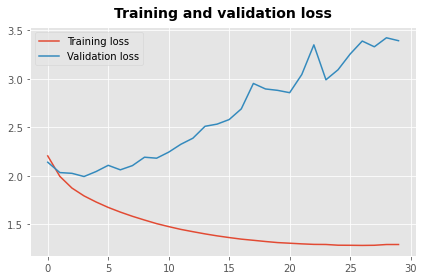

In [ ]:
plot_train_val_loss(dnn_model)

### Word Embeddingleri Görselleştirme

In [ ]:
# Modeldenn embedding layeri al
embedding_layer = model.layers[0]

# Embedding layerin ağırlıklarını al
embedding_weights = embedding_layer.get_weights()[0]

# Boyutunu yazdır
print(embedding_weights.shape) 

(191015, 16)


In [ ]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

In [ ]:
import io

# yazılabilen dosyalar aç
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, total_words):

  # o anki index ile ilişkili olan kelimeyi al
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  # o anki index ile ilişkili olan emmeding ağırlığını al
  word_embedding = embedding_weights[word_num]

  # kelimeyi dosyaya yazdır
  out_m.write(word_name + "\n")

  # emmedingi dosyaya yazdor
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Dosyaları kapat
out_v.close()
out_m.close()

Dosyaları indirelim ve https://projector.tensorflow.org/ adresine gidip word embeddingleri görselleştirelim

## 4. Sequential Modeller

Doğal dil işleme problemlerinde karşımıza çıkan veri tipi sequence (ardışık) şeklindedir. Ses tanıma (speech recognition), duygu sınıflandırma (sentiment classification), makine çevirisi (machine translation) gibi problemler Sequence Modeller ile çözüm bulabilir.

**Recurrent Neural Networks** ve **Long Short Term Memory** mimarileri en çok kullanılan sequential modellerdir.

### Recurrent Neural Networks

Doğal dil işleme problemlerini, standart yapay sinir ağları ile çözümlemeye çalışmak etkili olmayacaktır. Çünkü ağ, metindeki farklı konumlarda öğrenilen özellikleri paylaşmaz.

Örneğin, bir fotoğraf üzerindeki nesneleri kategorize etmek için eğitilen feedforward bir ağ düşünelim. Verilen fotoğraf rastgele bir sıra ile de olsa hem eğitim hem de test için kullanılabilir. Bir önceki veya bir sonraki fotoğraf ile herhangi bir bağının olması gerekmez. Yani zamana veya sıraya bağlı bir kavram yoktur, ilgilendiği tek input o andaki mevcut örnektir.

Recurrent(yinelenen) yapılarda ise sonuç, sadece o andaki inputa değil, diğer inputlara da bağlı olarak çıkarılır.




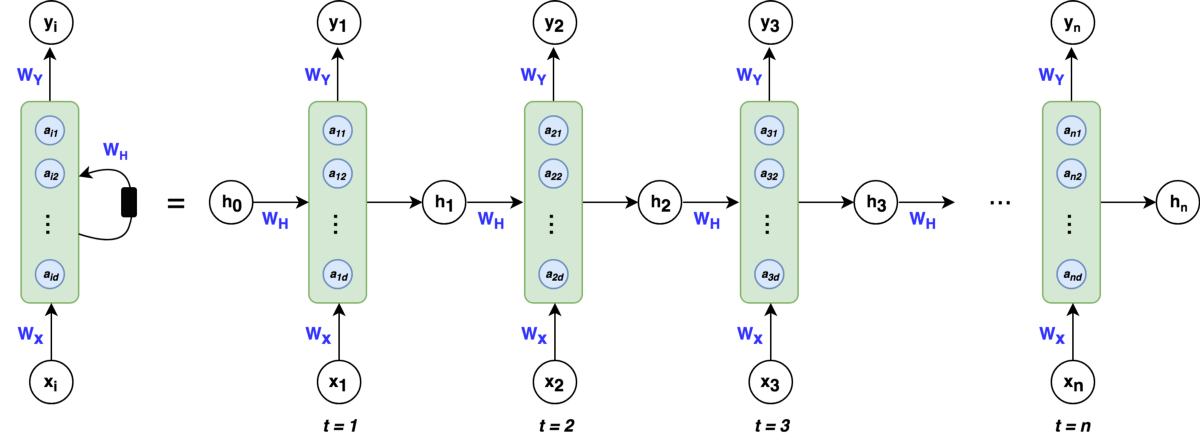

Şekilde görülen yeşil sütünlara **hidden state** adı verilir. 

Hidden state’in içindeki mavi çemberler a ile gösterilmiş olup, **hidden nodes** ya da **hidden units** adı verilir.

**H vektörü,** aktivasyon fonksiyonunun hidden node’lara uygulandıktan sonraki hidden state’in çıktısıdır.

Şekilde görüldüğü gibi t zamanında RNN önceki hidden state’ten yani (t-1)’den gelen h’yi ve t zamanındaki x girişini dahil ederek (t-1)’de olanları hesaba katar .Bu, ağın sırayla geçerli girdinin arkasında bulunan önceki girdilerden gelen bilgileri hesaba katmasına izin verir.

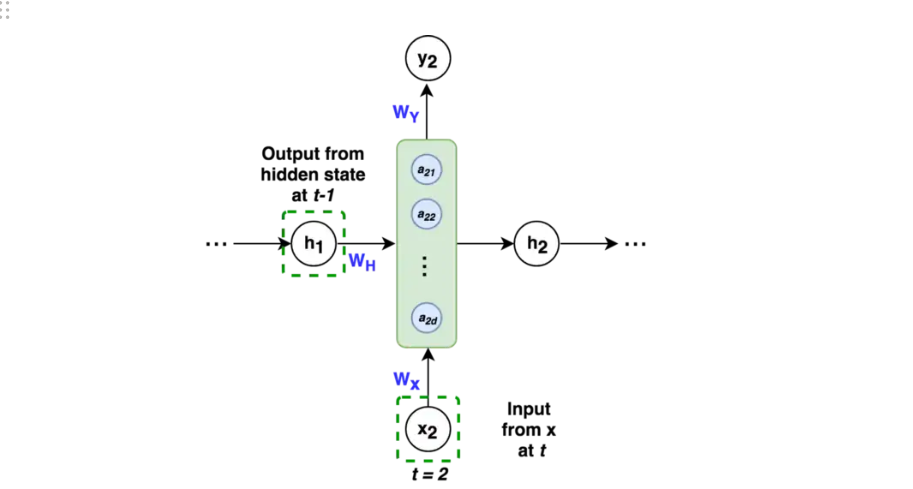

**Wx,Wy,Wh matrisleri,** Ağ boyunca paylaşılan RNN mimarisinin ağırlık matrisleridir.

 **X vektörü,** girdi dizisindeki her eleman için i = 1,2,3,….,n olan her bir hidden state’in girdisidir. Metin verileri numerik olarak ifade edilmelidir. Örneğin “dogs” kelimesinin one-hot yöntemiyle kodlanmış hali:

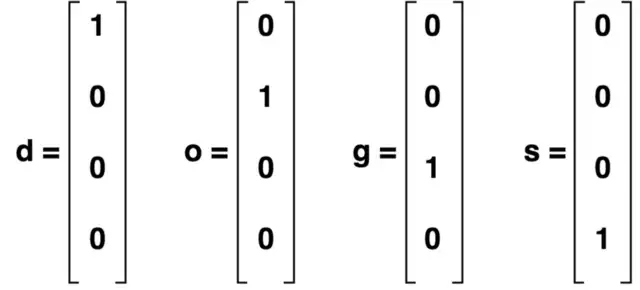

#### Hesaplamalar
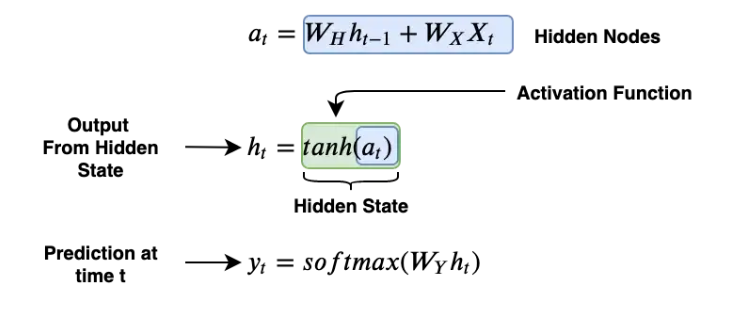

1. Hidden node, verilen girdiler ile hesaplanır.
2. Hidden node’a aktivasyon fonskiyonu uygulanır.
3. Sigmoid ya da softmax fonksiyonu ile tahmin değeri elde edilir.
4. Backpropagation yöntemi ile hatalar minimize edilene kadar ağırlıklar güncellenir.

#### Uygulama

- **Modeli tanımlama**

In [ ]:
rnn_model = tf.keras.Sequential([
    Embedding(total_words,16,input_length=maxlen),
    Bidirectional(SimpleRNN(64,dropout=0.1,recurrent_dropout=0.2,activation="tanh",return_sequences = True)),
    Bidirectional(SimpleRNN(64,dropout=0.1,recurrent_dropout=0.3,activation="tanh",return_sequences = True)),
    SimpleRNN(32,activation="tanh"),
    Dropout(0.2),
    Dense(42,activation="softmax")
])

rnn_model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )

rnn_model.summary()

Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding_1 (Embedding)     (None, 130, 16)           3054384   

                                                                 

 bidirectional (Bidirectiona  (None, 130, 128)         10368     

 l)                                                              

                                                                 

 bidirectional_1 (Bidirectio  (None, 130, 128)         24704     

 nal)                                                            

                                                                 

 simple_rnn_2 (SimpleRNN)    (None, 32)                5152      

                                                                 

 dropout (Dropout)           (None, 32)                0         

                                                                 

 dense_2 (Dense)             (None, 42

**Eğitim**

In [ ]:
rnn_history = rnn_model.fit(train_padded_seq, y_train, 
                   batch_size=128, 
                    epochs=15, 
                    validation_split=0.2,
                   )

# Model değerlendirme
test_loss, test_acc = model.evaluate(test_padded_seq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15

1048/1048 [==============================] - 208s 194ms/step - loss: 3.1756 - accuracy: 0.2025 - val_loss: 2.7748 - val_accuracy: 0.2946

Epoch 2/15

1048/1048 [==============================] - 202s 192ms/step - loss: 2.6579 - accuracy: 0.3230 - val_loss: 2.5244 - val_accuracy: 0.3465

Epoch 3/15

1048/1048 [==============================] - 201s 192ms/step - loss: 2.4129 - accuracy: 0.3778 - val_loss: 2.3576 - val_accuracy: 0.3937

Epoch 4/15

1048/1048 [==============================] - 200s 191ms/step - loss: 2.2334 - accuracy: 0.4219 - val_loss: 2.1729 - val_accuracy: 0.4397

Epoch 5/15

1048/1048 [==============================] - 201s 192ms/step - loss: 2.1197 - accuracy: 0.4525 - val_loss: 2.1309 - val_accuracy: 0.4547

Epoch 6/15

1048/1048 [==============================] - 200s 191ms/step - loss: 2.0300 - accuracy: 0.4766 - val_loss: 2.0754 - val_accuracy: 0.4741

Epoch 7/15

1048/1048 [==============================] - 200s 191ms/step - loss: 1.9657 - accuracy: 

**Train ve Test eğrileri**

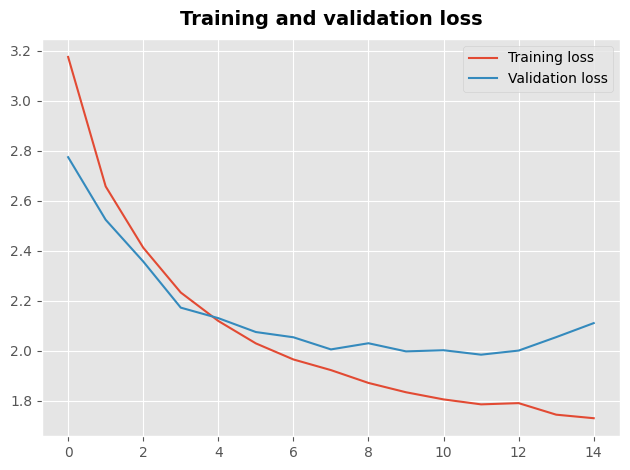

In [ ]:
plot_train_val_loss(rnn_history)

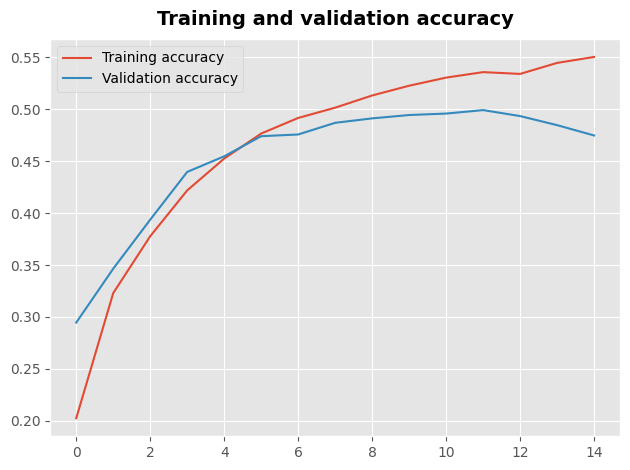

In [ ]:
plot_train_val_acc(rnn_history)

In [ ]:
# Oluşturulan modeli kaydet
rnn_model.save("models/rnn_model_exp01.h5")

In [ ]:
def save_history(history,filename):
  hist_df = pd.DataFrame(history.history)
  # save to json:  
  hist_json_file = filename
  with open(hist_json_file, mode='w') as f:
      hist_df.to_json(f)

save_history(rnn_history,"rnn_history.json")

### Long Short Term Memory

RNN mimarisinde *vanishing gradients* adlı sorundan kaynaklı olarak, ağın yararlı bilgileri tutma veya hatırlama yeteneği dizinin uzunluğu arttıkça azalır. Long Short Term Memory (LSTM) adlı yapay sinir ağı mimarisi, bu hatırlama sorununu hafifletmeye çalışan bir özel bir RNN türüdür.

LSTM’ler bir hafıza hücresi ve üç farklı kapıdan oluşur.

**LSTM'de hafıza hücresi**, uzun süreler boyunca bilgi saklayabilen bir durumdur. Bu amaçla, hücre içine ve hücre dışına bilgi akışını kontrol etmek için üç kapıyı kullanır.

**Giriş kapısı,** hücreye yeni bilgi yazılmasını sağlar, **çıkış kapısı** hücreden bilgi akışını kontrol eder ve unutma kapısı hücreden hangi bilgilerin atılacağını belirler.

#### Pre-trained Embedding Kullanmak

Pre-trained embedding yani önceden eğitilmiş embeddingler çok büyük veri setleriyle eğitilmiş ve kullanım hazırdır.

GloVe word embeddings Stanford Üniversitesi tarafında geliştirilmiştir. Açılımı Global Word Representation for Represantation'dur.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip #Glove embedding indirme

--2022-12-22 12:15:03--  http://nlp.stanford.edu/data/glove.6B.zip

Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140

Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.

HTTP request sent, awaiting response... 302 Found

Location: https://nlp.stanford.edu/data/glove.6B.zip [following]

--2022-12-22 12:15:03--  https://nlp.stanford.edu/data/glove.6B.zip

Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.

HTTP request sent, awaiting response... 301 Moved Permanently

Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]

--2022-12-22 12:15:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22

Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.

HTTP request sent, awaiting response... 200 OK

Length: 862182613 (822M) [application/zip]

Saving to: ‘glove

In [ ]:
!unzip -q glove.6B.zip #unzipping 

In [ ]:
path_to_glove_file =  './glove.6B.100d.txt'

In [ ]:
#Glove pre trained embeddingler ile embeddihg matrisini oluşturma

num_tokens = len(tokenizer.word_index.items()) + 2
embedding_dim = 100
hits = 0
misses = 0


embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.

Converted 55644 words (135371 misses)


In [ ]:
# Oluşturulan embedding matrisi
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.091682  ,  0.58104998,  0.40476999, ..., -0.38741001,
         0.34694999,  0.229     ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

**Early Stopping Callback'i tanımlama**

Callback'ler her bir epoch sonunda çalıştırılan fonksiyonlardır.

Burada ovefitting engellemek için bir fonkisyon tanımlıyoruz.
Eğitim hatası ve test hatası birlikte düşerken bir noktadan sonra train hatası hala düşmeye devam ederken test hatasının artmaya başlaması aşırı öğrenme sorunun olduğunu gösterir.

Test hatasının artmaya başladığı yerde eğitimi yarıda kesme işlemine **early stopping** denir.

In [ ]:
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )

callback_list = [earlystopping]

In [ ]:
tf.keras.backend.clear_session()
embed_size = 100
lstm_model = keras.models.Sequential([
        Embedding(num_tokens,embedding_dim,embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        mask_zero=True,input_shape=[None],trainable=False),
        Bidirectional(LSTM(256, dropout = 0.4)),
        Dense(42, activation="softmax")
        ])



lstm_model.compile(optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )


lstm_model.summary()

Model: "sequential"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


embedding (Embedding)        (None, None, 100)         19101700  

_________________________________________________________________

bidirectional (Bidirectional (None, 512)               731136    

_________________________________________________________________

dense (Dense)                (None, 42)                21546     


Total params: 19,854,382

Trainable params: 752,682

Non-trainable params: 19,101,700

_________________________________________________________________


In [ ]:
num_epochs = 20
lstm_history = lstm_model.fit(train_padded_seq, y_train,
                             batch_size = 128,
                             validation_split=0.2,
                             callbacks = callback_list,
                             epochs = num_epochs
                             )

# evalute the model
test_loss, test_acc = model.evaluate(test_padded_seq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/20

1048/1048 [==============================] - 654s 624ms/step - loss: 1.8274 - accuracy: 0.5002 - val_loss: 1.6219 - val_accuracy: 0.5468

Epoch 2/20

1048/1048 [==============================] - 648s 619ms/step - loss: 1.5682 - accuracy: 0.5584 - val_loss: 1.4851 - val_accuracy: 0.5793

Epoch 3/20

1048/1048 [==============================] - 661s 631ms/step - loss: 1.4655 - accuracy: 0.5813 - val_loss: 1.4335 - val_accuracy: 0.5916

Epoch 4/20

1048/1048 [==============================] - 655s 625ms/step - loss: 1.3957 - accuracy: 0.5970 - val_loss: 1.3967 - val_accuracy: 0.5999

Epoch 5/20

1048/1048 [==============================] - 662s 632ms/step - loss: 1.3375 - accuracy: 0.6119 - val_loss: 1.3798 - val_accuracy: 0.6044

Epoch 6/20

1048/1048 [==============================] - 660s 630ms/step - loss: 1.2882 - accuracy: 0.6228 - val_loss: 1.3542 - val_accuracy: 0.6117

Epoch 00006: early stopping

test loss and accuracy: 3.3925960063934326 0.3757457137107849


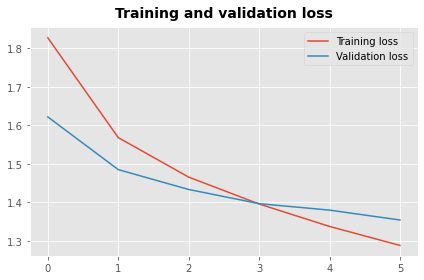

In [ ]:
plot_train_val_loss(lstm_history)

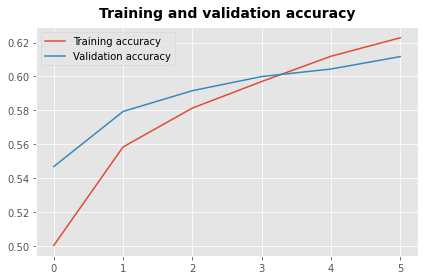

In [ ]:
plot_train_val_acc(lstm_history)

In [ ]:
lstm_model.save("models/lstm_model_exp01.h5")

# 5. Tahminleme

In [ ]:
# Modeli yükle
lstm_model = keras.models.load_model("/content/models/lstm_model_exp01.h5")

In [ ]:
def predict_category(model,headline,encoder):
  # clean_text fonksiyonunu uygula
  headline = [clean_text(new_headline)]
  # Padded sequence haline getir
  headline_seq = tokenizer.texts_to_sequences(headline)
  headline_seq_padded = pad_sequences(headline_seq,maxlen=130)

  probabilities = lstm_model.predict(headline_seq_padded)
  predicted_class = tf.argmax(probabilities, axis=1)

  return encoder.inverse_transform(predicted_class)[0]

In [ ]:
new_headline = "The Best Grocery Store Eggnogs For Spiking, According To Bartenders"

category = predict_category(lstm_model,new_headline,encoder)

print(f"Tahmin edilen kategori: {category}")

1/1 [==============================] - 0s 112ms/step

Tahmin edilen kategori: ENTERTAINMENT
